#Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import gdown
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from numpy.core.fromnumeric import transpose
from PIL import Image, ImageOps
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

from keras.datasets import mnist


#Helper Functions

In [ ]:
# def make_image_grid(imgs, nrows=1, border_size=2):
#     N, H, W = imgs.shape
#     ncols = int(np.ceil(N / nrows))
#     pad = border_size // 2
#     imgs = (imgs * 255 / imgs.max()).astype(np.uint8)
#     padded = np.pad(imgs, ((0, 0), (pad, pad), (pad, pad)), 'constant', constant_values=255)
#     if N < ncols * nrows:
#         _, H, W = padded.shape
#         blank = 255 * np.ones((ncols * nrows - N, H, W), dtype=padded.dtype)
#         padded = np.concatenate((padded, blank))
#     grid = np.vstack([np.hstack(padded[r * ncols:(r + 1) * ncols]) for r in range(nrows)])
    
#     return grid

# def confusion_matrix(y_pred, y_true, num_classes):
#     confusion = np.zeros((num_classes, num_classes), dtype=int)
#     for i in range(num_classes):
#         true_i = (y_true == i).nonzero()
#         labels, counts = np.unique(y_pred[true_i], return_counts=True)
#         confusion[i, labels] = counts

#     return confusion

# def plot_confusion(confusion, num_classes):
#     confusion = confusion / confusion.sum(1)

#     plt.imshow(confusion, cmap=plt.get_cmap('viridis'))
#     plt.xlabel("Predicted Class")
#     plt.ylabel("True Class")
#     plt.colorbar()
#     plt.xticks(np.arange(num_classes))
#     plt.yticks(np.arange(num_classes))

def load_image(path):
    """Load and formant a single image into memory"""
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image = image.resize((28, 28))
    return image

def load_handwritten_images(path): 
    """
    Load images from folder
    """
    files = [os.path.join(dirpath,f) 
        for (dirpath, _, filenames) 
        in os.walk(path) 
        for f in filenames]
    images = []
    labels = []
    for file_path in files:
        label = int(file_path.split("/")[-1][0])
        image = file_path
        
        images.append(image) 
        labels.append(label)

    images = images
    labels = labels
    return (images, labels)

def calc_acc(dataloader, device, svm, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            if svm == False:
                outputs = net(images)
                predicted = torch.argmax(outputs, dim=1)
            else:
                scores = net(images.view(images.size(0), -1))
                predicted = torch.argmax(scores, dim=1)
            # the class with the highest energy is what we choose as prediction
            # print(labels.shape, outputs.shape, predicted.shape)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total)

#Rob 102 Dataset

In [ ]:
url = "https://drive.google.com/uc?id=1QcYFeGgyn-rOmOQPjasyI9bwGfJJvBhX"
output = "rob102_handwriting.zip"
gdown.download(url, output, quiet=False)

!unzip -q -o /content/rob102_handwriting.zip

x_rob102, y_rob102 = load_handwritten_images("/content/rob102_handwriting")

Downloading...
From: https://drive.google.com/uc?id=1QcYFeGgyn-rOmOQPjasyI9bwGfJJvBhX
To: /content/rob102_handwriting.zip
100%|██████████| 1.66M/1.66M [00:00<00:00, 119MB/s]


In [ ]:
class Rob_102(Dataset):
    def __init__(self, img, labels, size, transform=None, target_transform=None):


        self.labels = labels
        self.img = img
        self.transform = transform
        self.target_transform = target_transform
        self.size = size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.img[idx]
        image = Image.open(image_path)
        image = image.resize((self.size))
        image = ImageOps.invert(image)
        image = image.convert('RGB')
        #image.show()
        img_tensor = torch.tensor(np.array(image), dtype=torch.float)
        img_tensor = img_tensor/255
        img_tensor = img_tensor.transpose(0, -1)

        label = self.labels[idx]
        #print(label)
        return img_tensor, label

In [ ]:
full_dataset = Rob_102(x_rob102, y_rob102, (32,32))

batch_size = 10

rob102_test_dataloader = DataLoader(full_dataset, batch_size, shuffle=True)

#MNIST Dataset and Networks

In [ ]:

# Define a transformation to convert the data to PyTorch tensors
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                                ])


# Load the MNIST training and test datasets using torchvision.datasets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 10

# Create data loaders for the training and test datasets
MNIST_train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
MNIST_test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 137458544.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 9989748.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38442121.33it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14542388.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
width = 6

class MNIST_convo_nn(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, width, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(width, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 180)
        self.fc2 = nn.Linear(180, 94)
        self.fc3 = nn.Linear(94, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MNIST_full_nn(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.fc1 = nn.Linear(3072, 180)
        self.fc2 = nn.Linear(180, num_classes)  # output size: 10 classes

    def forward(self, x):
        #print(x.shape)
        x = x.view(-1, 3072)  # flatten the input tensor
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        #print(x[0])
        #x = x.transpose(0, -1)
        #print('x_shape:',x.shape)
        return x


class MNIST_SVM(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, 10)  # multiply by 3 for 3 input channels
    
    def forward(self, x):
        #out = x.requires_grad_()
        out = x.view(x.size(0), -1)  # flatten the input tensor
        out = self.linear(out)
        return out



#Traffic Dataset and Networks

***Traffic Dataset V1***

In [ ]:
# url = "https://drive.google.com/uc?id=1t3Mt46C2G9fWlRY31_QqFNy4ZyoaeIMQ"
# output = "traffic_dataset.zip"
# gdown.download(url, output, quiet=False)

# !unzip -q -o /content/traffic_dataset.zip

***Traffic Dataset V2***

In [ ]:
# url = "https://drive.google.com/uc?id=1dEUFggWzHBLI-ObiWK3nlOKx1-JgDZWp"
# output = "traffic_datasetV2.zip"
# gdown.download(url, output, quiet=False)

# !unzip -q -o /content/traffic_datasetV2.zip

***Traffic Dataset V3***

In [ ]:
# url = "https://drive.google.com/uc?id=1MOIAtm0Uu5tRJp7gE9N5onLSkxRdcHnX"
# output = "traffic_datasetV3.zip"
# gdown.download(url, output, quiet=False)

# !unzip -q -o /content/traffic_datasetV3.zip

***Traffic Dataset V4***

In [ ]:
url = "https://drive.google.com/uc?id=1XXtzVtwM-sGjwON7mfwsSdTfYDnCe80e"
output = "traffic_datasetV4.zip"
gdown.download(url, output, quiet=False)

!unzip -q -o /content/traffic_datasetV4.zip

Downloading...
From: https://drive.google.com/uc?id=1XXtzVtwM-sGjwON7mfwsSdTfYDnCe80e
To: /content/traffic_datasetV4.zip
100%|██████████| 387M/387M [00:04<00:00, 89.0MB/s]


***Extracting Data***

In [ ]:
class TrafficDataset(Dataset):
    def __init__(self, annotations, img_dir,size, transform=None, target_transform=None):
        jsons_to_combine = [f for f in os.listdir(annotations) if (f.endswith('.json'))]
        jsons_to_combine =  sorted([int(x[0:4]) for x in jsons_to_combine])
        jsons_to_combine =  [str(x).rjust(4,"0")+'.json' for x in jsons_to_combine]

        data = {}

        c = 0
        for j in jsons_to_combine:
            with open(annotations +j, "r") as f:
                label = int(json.load(f)['cat'])
            data[j[0:4]]  = label
            c += 1
        
        self.img_labels = data

        print(self.img_labels)
        print(self.img_labels.keys())
        print("len: {0}".format(len(self.img_labels)))

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.size = size

    def __len__(self):
        return len(self.img_labels.keys())

    def __getitem__(self, idx):
        key = str(idx).rjust(4,'0')
        img_path = os.path.join(self.img_dir, key+".PNG")
        image = Image.open(img_path)
        image = image.resize((self.size))
        image = image.convert('RGB')
        img_tensor = torch.tensor(np.array(image), dtype=torch.float)
        img_tensor = img_tensor/255
        img_tensor = img_tensor.transpose(0, -1)

        label = self.img_labels[key]

        return img_tensor, label

In [ ]:
full_dataset = TrafficDataset("/content/Final/newLabels/", "/content/Final/newImages/", (32,32))

train_size = 6000
test_size = len(full_dataset) - train_size
training_data,test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])


batch_size = 10

traffic_train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
traffic_test_dataloader = DataLoader(test_data, batch_size, shuffle=True)


{'0000': 2, '0001': 2, '0002': 2, '0003': 2, '0004': 1, '0005': 1, '0006': 1, '0007': 2, '0008': 2, '0009': 2, '0010': 1, '0011': 1, '0012': 1, '0013': 1, '0014': 1, '0015': 2, '0016': 2, '0017': 1, '0018': 1, '0019': 1, '0020': 1, '0021': 1, '0022': 1, '0023': 1, '0024': 1, '0025': 2, '0026': 1, '0027': 1, '0028': 1, '0029': 1, '0030': 1, '0031': 1, '0032': 1, '0033': 1, '0034': 1, '0035': 1, '0036': 2, '0037': 1, '0038': 1, '0039': 1, '0040': 1, '0041': 1, '0042': 1, '0043': 2, '0044': 1, '0045': 1, '0046': 0, '0047': 2, '0048': 1, '0049': 1, '0050': 1, '0051': 0, '0052': 2, '0053': 2, '0054': 2, '0055': 1, '0056': 2, '0057': 1, '0058': 2, '0059': 1, '0060': 1, '0061': 2, '0062': 1, '0063': 2, '0064': 1, '0065': 1, '0066': 2, '0067': 1, '0068': 2, '0069': 2, '0070': 2, '0071': 2, '0072': 1, '0073': 2, '0074': 1, '0075': 1, '0076': 1, '0077': 2, '0078': 2, '0079': 2, '0080': 0, '0081': 1, '0082': 2, '0083': 2, '0084': 2, '0085': 2, '0086': 2, '0087': 2, '0088': 0, '0089': 2, '0090': 1

In [ ]:
width = 6

class Traffic_convo_nn(nn.Module):
    def __init__(self, num_classes = 6):
        super().__init__()
        self.conv1 = nn.Conv2d(3, width, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(width, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 180)
        self.fc2 = nn.Linear(180, 94)
        self.fc3 = nn.Linear(94, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Traffic_full_nn(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.fc1 = nn.Linear(3072, 180)
        self.fc2 = nn.Linear(180, num_classes)  # output size: 10 classes

    def forward(self, x):
        #print(x.shape)
        x = x.view(-1, 3072)  # flatten the input tensor
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        #print(x[0])
        #x = x.transpose(0, -1)
        #print('x_shape:',x.shape)
        return x

# Training

 **GPU Device and Dataset Selection**

In [ ]:
#Declare which network you want to use
net = Traffic_convo_nn()#MNIST_SVM(3072)

#Where the network will be saved
pathname = "traffic_convo_nn"

#Choose the Dataloader you need
test_dataloader  = traffic_test_dataloader
train_dataloader = traffic_train_dataloader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)
#eps for con traffic 60 or 20
#eps for con MNIST 5
#eps for full 10
#eps for svm 5
eps = 20

lr = .001

svm = False

cuda:0


**Training NN**

[1,     1] loss: 1.8584554195404053
Accuracy of the network on the test images: 58.3989501312336 %
[2,     1] loss: 0.889193058013916
Accuracy of the network on the test images: 66.92913385826772 %
[3,     1] loss: 0.5990268588066101
Accuracy of the network on the test images: 68.50393700787401 %
[4,     1] loss: 1.4136571884155273
Accuracy of the network on the test images: 70.07874015748031 %
[5,     1] loss: 0.9734734296798706
Accuracy of the network on the test images: 73.35958005249343 %
[6,     1] loss: 0.5218393802642822
Accuracy of the network on the test images: 72.30971128608924 %
[7,     1] loss: 0.6510809063911438
Accuracy of the network on the test images: 73.49081364829397 %
[8,     1] loss: 0.4874936044216156
Accuracy of the network on the test images: 75.7217847769029 %
[9,     1] loss: 0.201552152633667
Accuracy of the network on the test images: 73.49081364829397 %
[10,     1] loss: 0.29314443469047546
Accuracy of the network on the test images: 74.01574803149606 %
[1

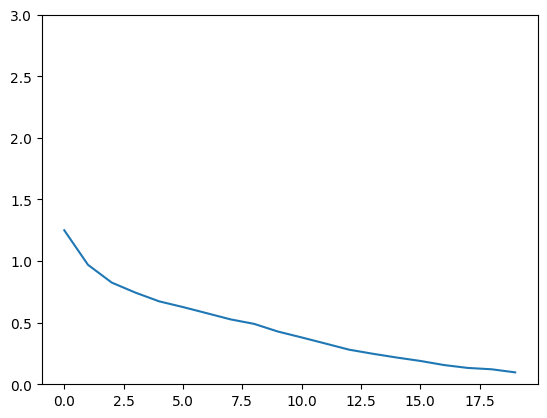

In [ ]:
start =  time.time()
losses  = []
net.train()

if (svm):
  criterion = torch.nn.MultiMarginLoss()
else:
  criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr)

#print(list(net.parameters()))

for epoch in range(eps):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        if(svm == False):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
        elif(svm == True):
          scores = net(inputs.view(inputs.size(0), -1))
          loss = criterion(scores, labels)


        loss.backward()
        optimizer.step()

        

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item()}')
    losses.append(running_loss / (i+1))
    if (epoch % 10 == 0 or 1 ==1):
        acc = calc_acc(test_dataloader,device,svm,net)
        print(f'Accuracy of the network on the test images: {100 * acc} %')

end = time.time()
print('Finished Training')
print((end- start)/60)

plt.figure()
plt.ylim(0, 3)
for i in range(0,2):
  print(losses[i])
#losses
plt.plot(np.arange(len(losses)),losses)

PATH = './'+ pathname + '.pth'
torch.save(net.state_dict(), PATH)


acc = calc_acc(test_dataloader,device,svm,net)

print(f'Accuracy of the network on the test images: {100 * acc} %')
print("Here is the loss graph")


#STATS

In [ ]:
from pickle import TRUE
PATH = '/content/traffic_convo_nn.pth'

net = Traffic_convo_nn()#MNIST_SVM(3072)
net.load_state_dict(torch.load(PATH))
net.to(device)

test_dataloader  = traffic_test_dataloader
train_dataloader = traffic_train_dataloader

# classes = ('StopSign', 'CrossWalk', 'TrafficLight', 'ParkingMeter', 'Car', 'Bike')
classes = ('Stop', 'Cross', 'Light', 'Meter', 'Car', 'Bike')
#classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
svm = False


In [ ]:
acc = calc_acc(test_dataloader, device, svm, net)

print(f'Accuracy of the network on the test images: {100 * acc} %')

acc = calc_acc(train_dataloader, device, svm, net)

print(f'Accuracy of the network on the train images: {100 * acc} %')

acc = calc_acc(rob102_test_dataloader, device, svm, net)
print(f'Accuracy of the network on the rob_102 images: {100 *acc} %')





Accuracy of the network on the test images: 10.416666666666668 %
Accuracy of the network on the train images: 98.97333333333333 %
Accuracy of the network on the rob_102 images: 10.416666666666668 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('On the Test')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


On the Test
Accuracy for class: 0     is 58.3 %
Accuracy for class: 1     is 0.0 %
Accuracy for class: 2     is 8.3 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 29.2 %
Accuracy for class: 5     is 0.0 %
Accuracy for class: 6     is 0.0 %
Accuracy for class: 7     is 0.0 %
Accuracy for class: 8     is 8.3 %
Accuracy for class: 9     is 0.0 %


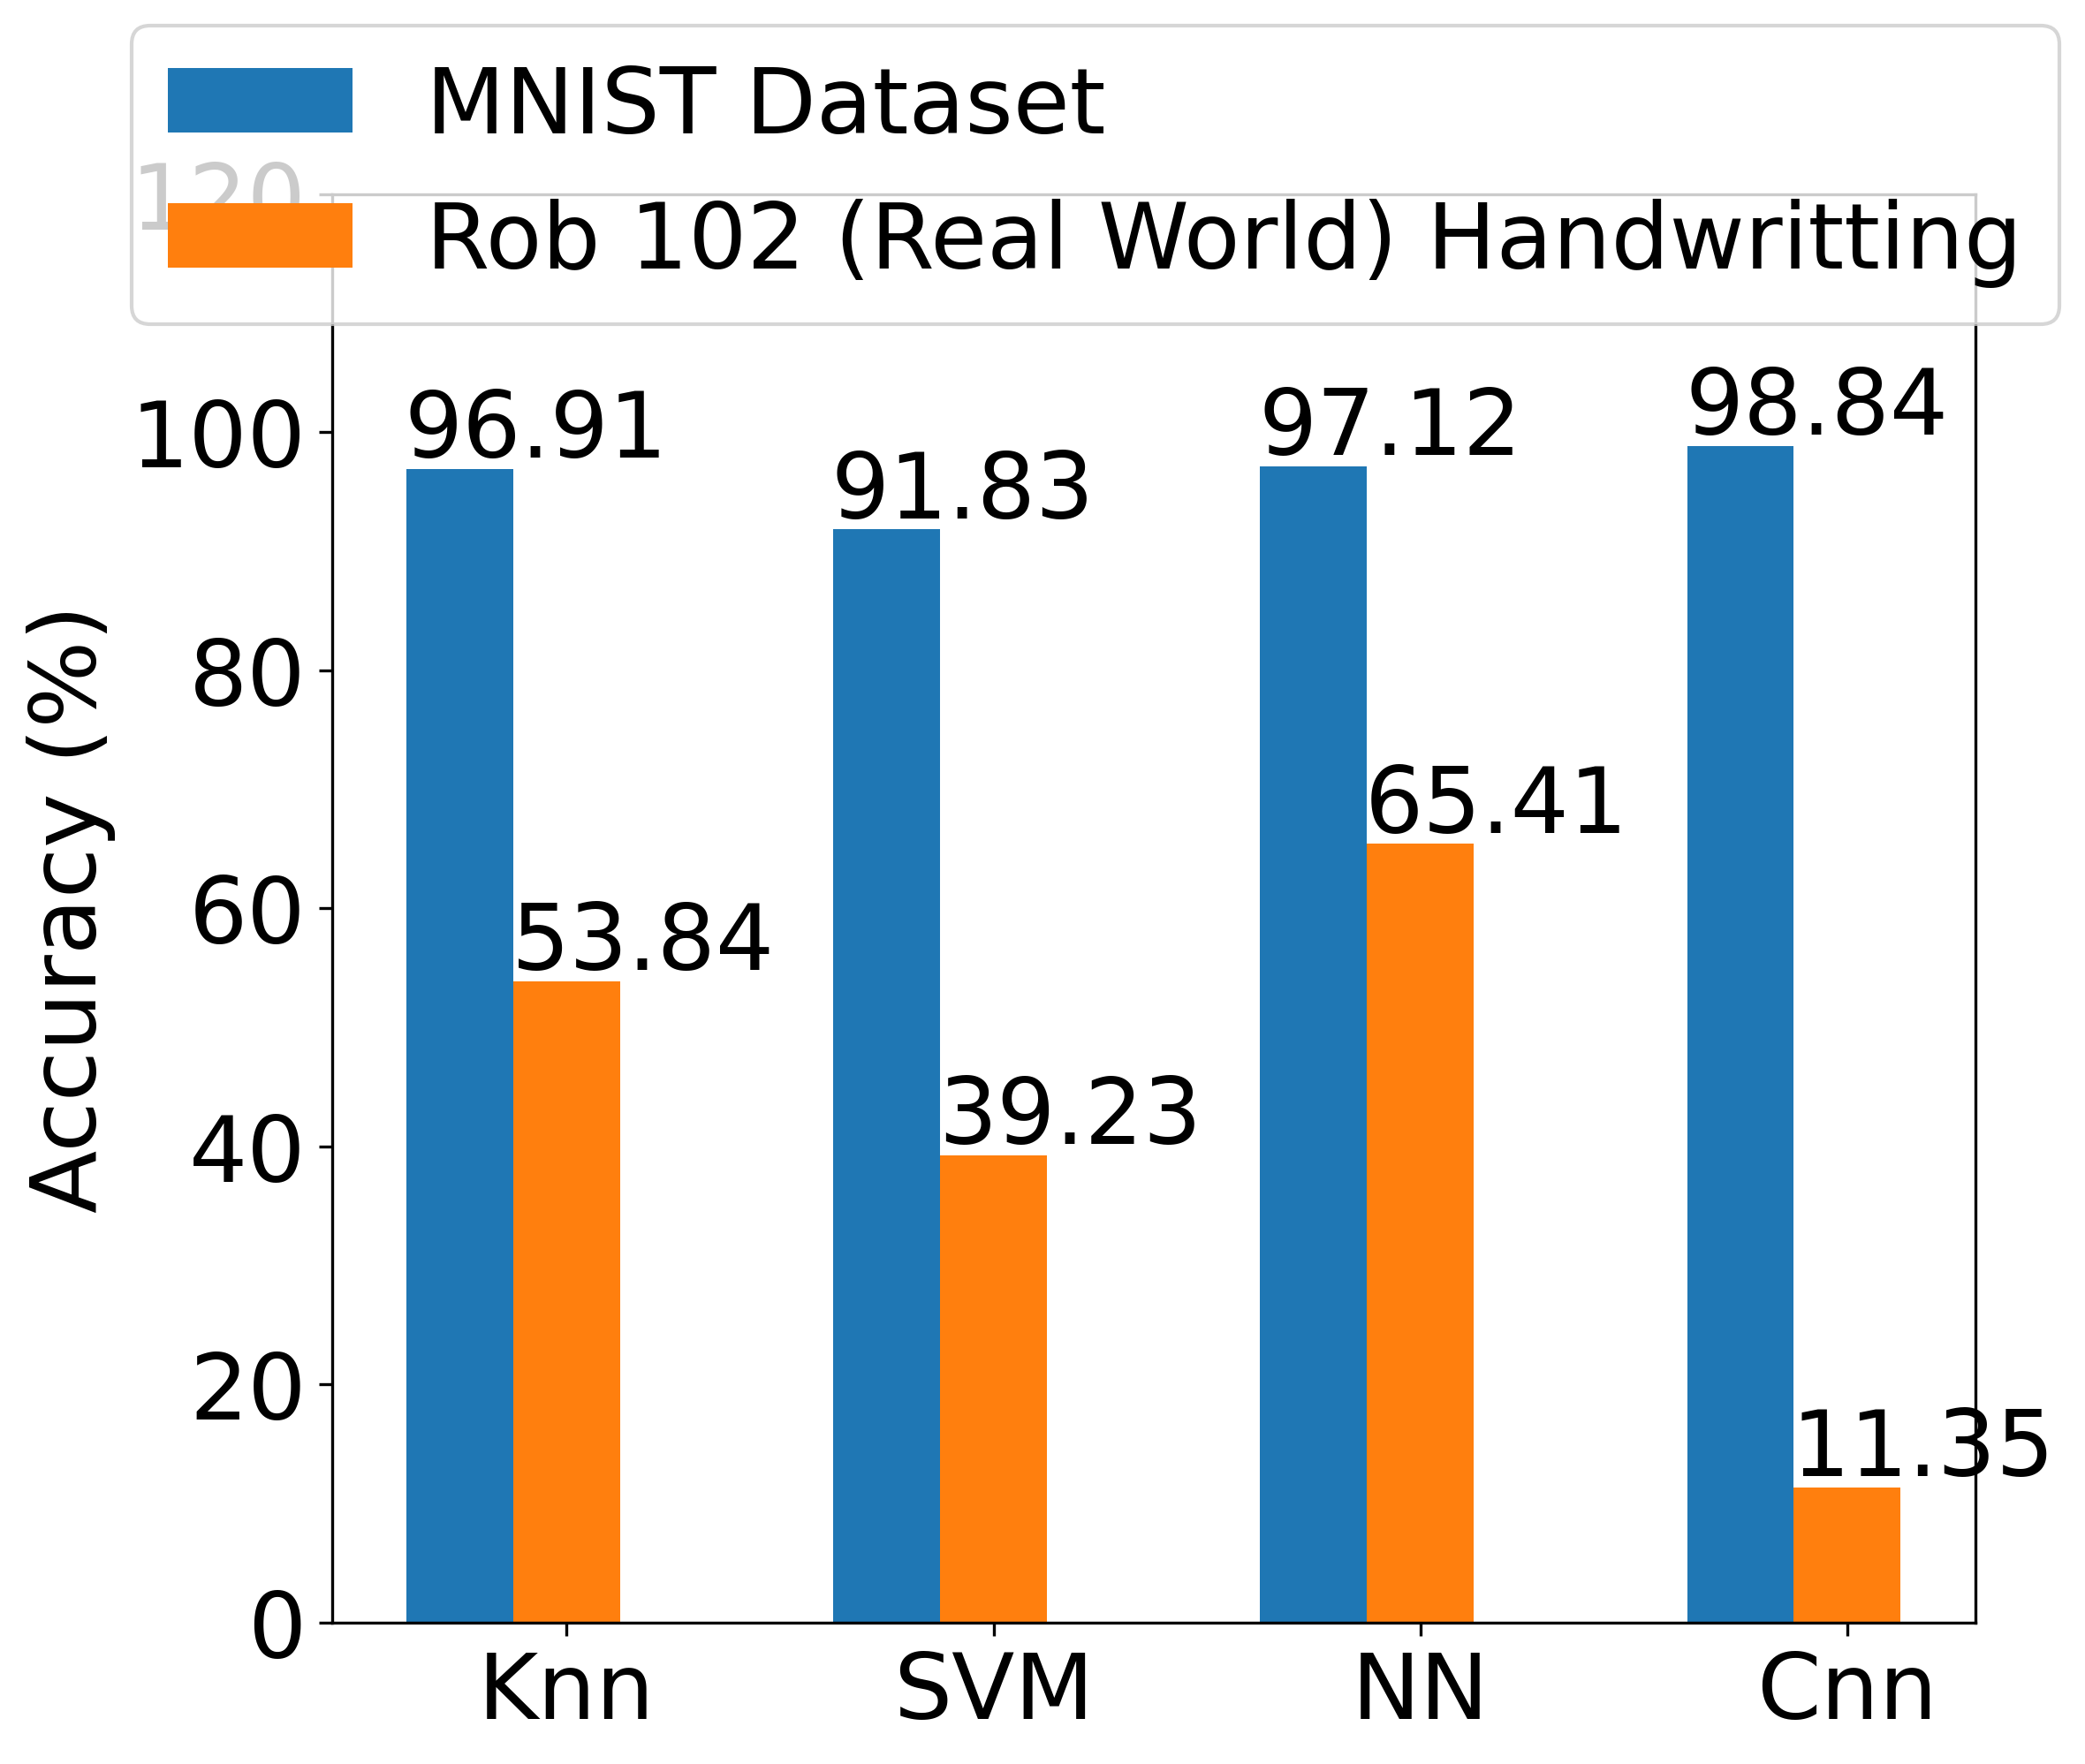

In [ ]:
# create data
categories = ['Knn','SVM', 'NN', 'Cnn']
mnist_acc = [96.91,91.83, 97.12, 98.84]
rob102_acc = [53.84,39.23, 65.41, 11.35]
#traffic_acc = [55.27, 63.19, 72.25]

# set width of the bars
bar_width = 0.25

# set positions of the bars on the x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
# r3 = [x + bar_width for x in r2]


plt.rcParams.update({'font.size': 25})

# create figure with desired size
fig = plt.figure(figsize=(8, 7), dpi=300)

# plot the bars  
#plt.bar(r1, traffic_acc,  width=bar_width, label='Autonomous Car Dataset',)
plt.bar(r1, mnist_acc, width=bar_width, label='MNIST Dataset')
plt.bar(r2, rob102_acc, width=bar_width, label='Rob 102 (Real World) Handwritting')

# add x-axis labels and ticks
plt.xticks([r + bar_width for r in range(len(categories))], categories)

# add y-axis label and range
plt.ylabel('Accuracy (%)',)
plt.ylim(0, 120)

# add legend to the top right corner
plt.legend(loc='upper left', bbox_to_anchor=(-.15, 1.15))


# add number labels to each bar
for i in range(len(r1)):
    plt.text(x=r1[i]-0.13, y=mnist_acc[i]+1, s=str(mnist_acc[i]))
    plt.text(x=r2[i]-0.13, y=rob102_acc[i]+1, s=str(rob102_acc[i]))
    #plt.text(x=r1[i]-0.06, y=traffic_acc[i]+1, s=str(traffic_acc[i]))

# show the plot
plt.show()


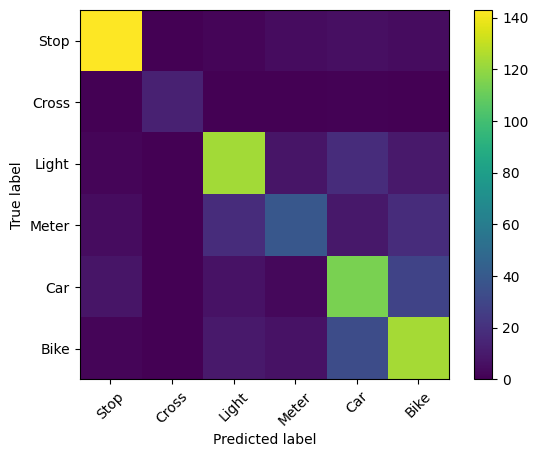

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

categories = classes

# define empty arrays to store true labels and predicted labels
true_labels = np.array([])
predicted_labels = np.array([])

# loop over the test dataset and make predictions
for images, labels in test_dataloader:
    # make predictions
    predictions = net(images.to(device))

    # get the predicted labels
    predicted = torch.argmax(predictions, dim=1).cpu().numpy()

    # add true and predicted labels to arrays
    true_labels = np.concatenate([true_labels, labels.numpy()])
    predicted_labels = np.concatenate([predicted_labels, predicted])

# create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# visualize confusion matrix
import matplotlib.pyplot as plt

plt.imshow(cm, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

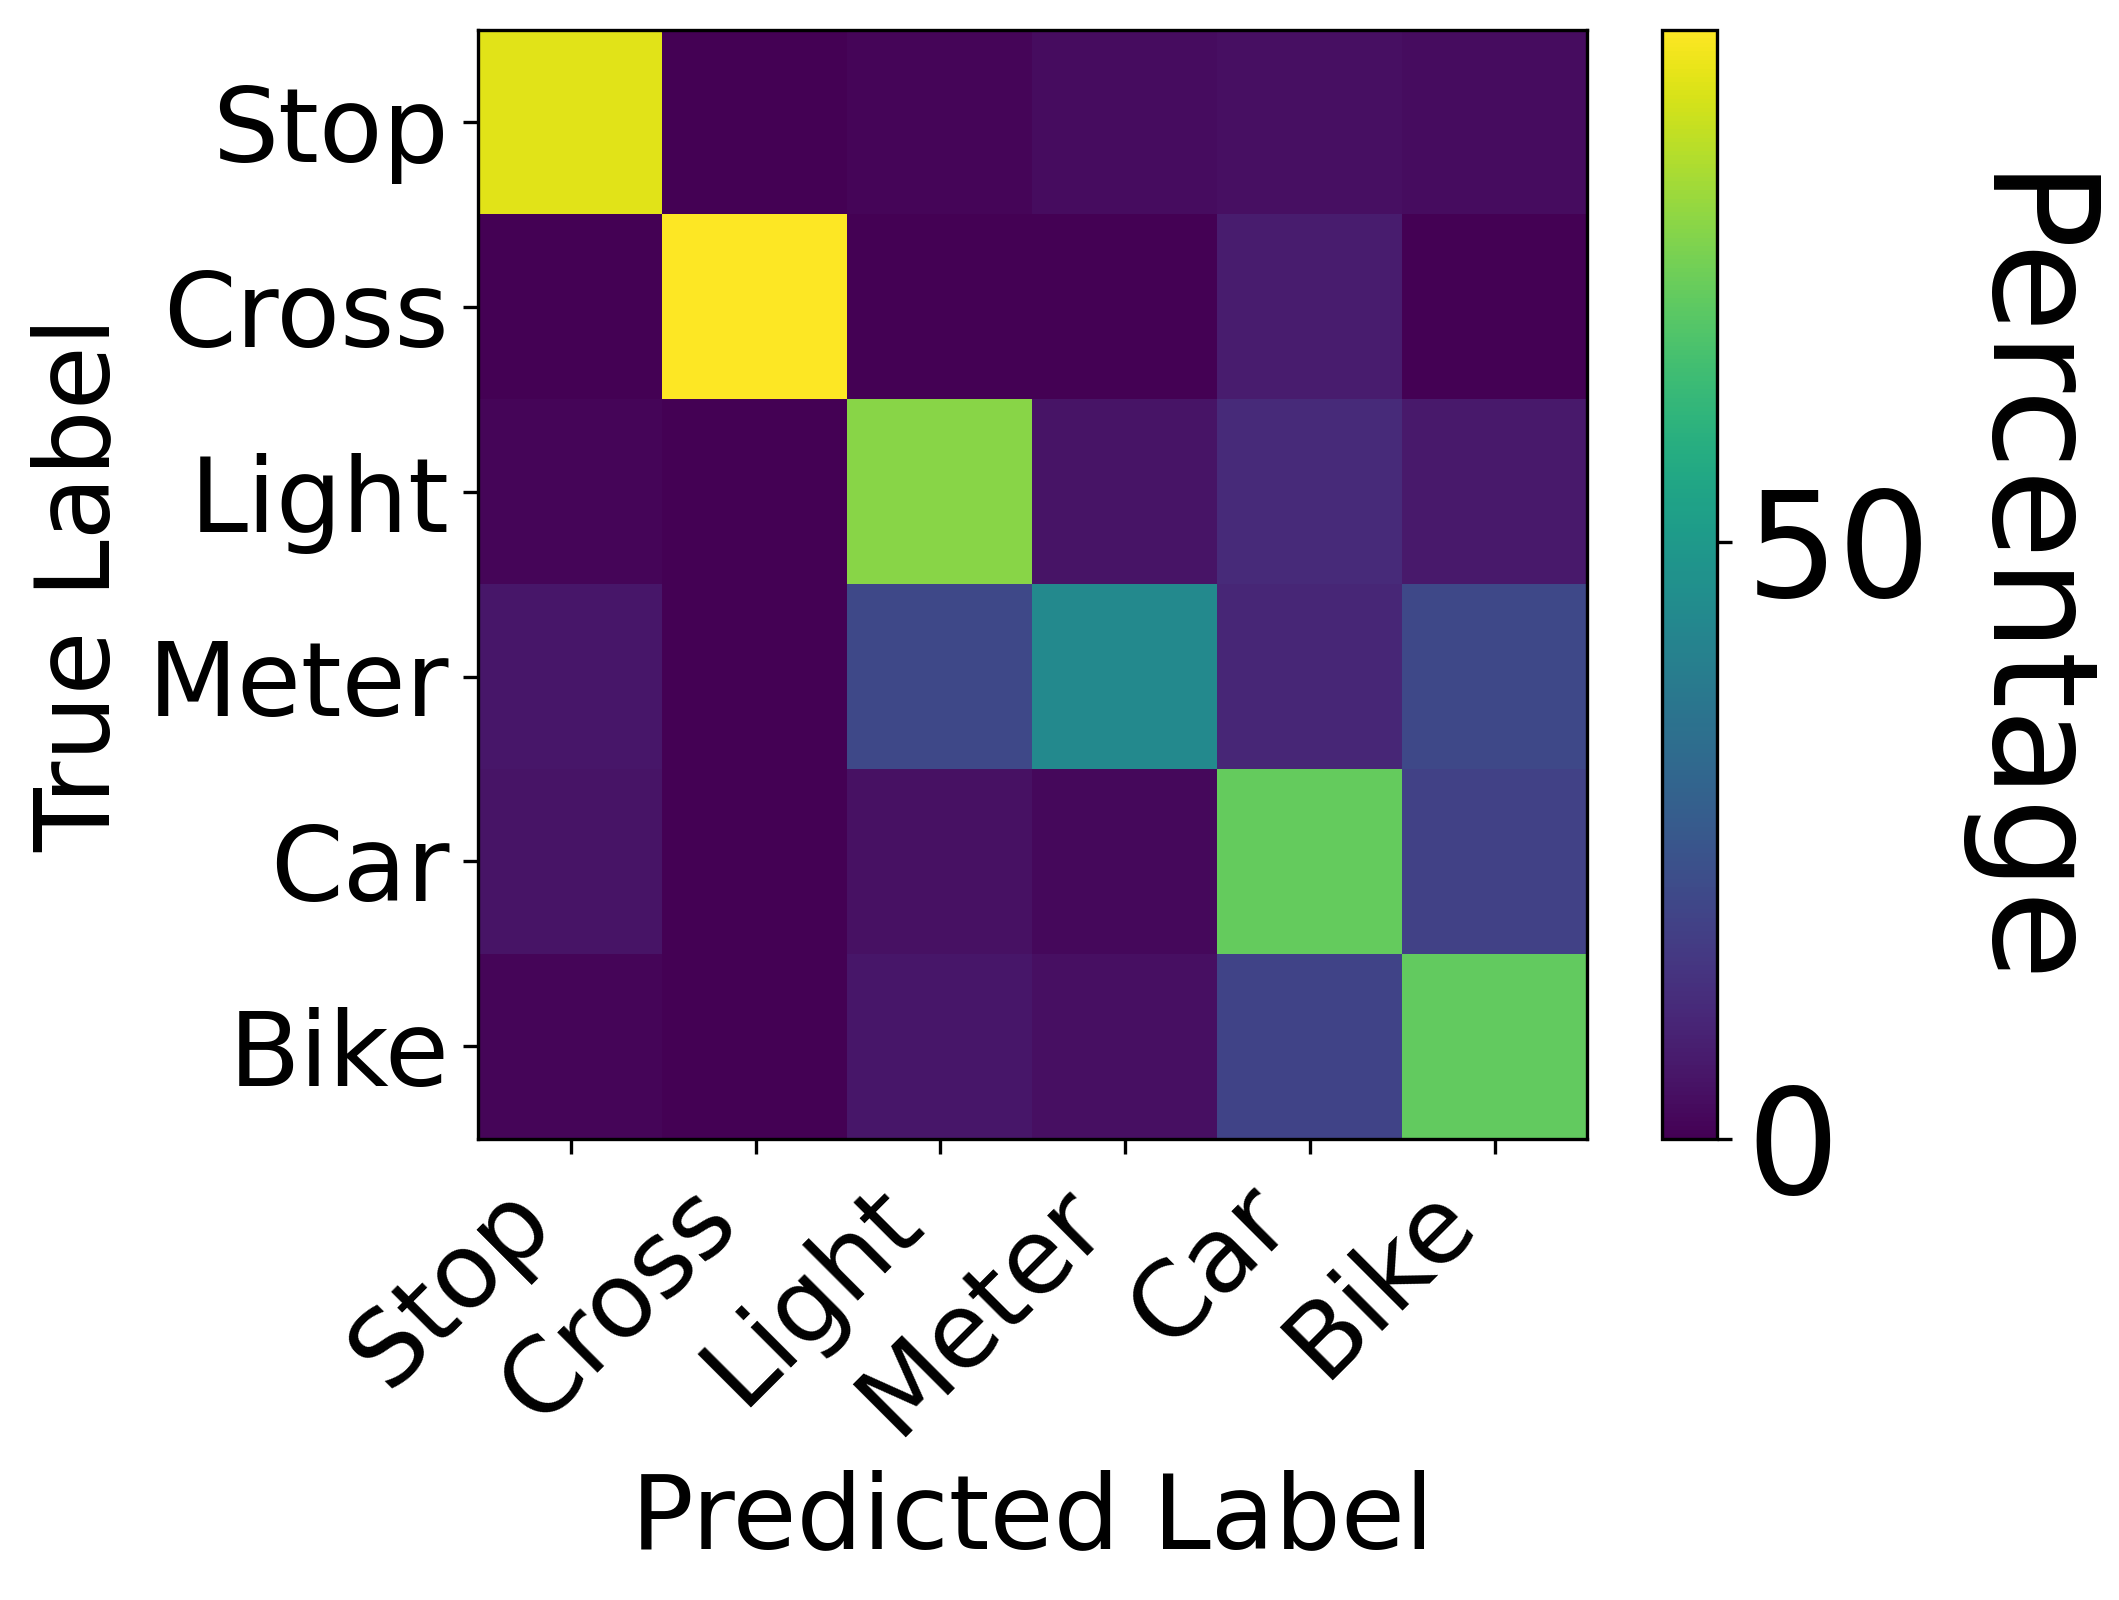

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# define empty arrays to store true labels and predicted labels
true_labels = np.array([])
predicted_labels = np.array([])

# loop over the test dataset and make predictions
for images, labels in test_dataloader:
    # make predictions
    predictions = net(images.to(device))

    # get the predicted labels
    predicted = torch.argmax(predictions, dim=1).cpu().numpy()

    # add true and predicted labels to arrays
    true_labels = np.concatenate([true_labels, labels.numpy()])
    predicted_labels = np.concatenate([predicted_labels, predicted])

# calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# calculate percentages by category
percentages_by_category = {}
for i, category in enumerate(categories):
    category_total = cm[i, :].sum()
    category_correct = cm[i, i]
    category_incorrect = category_total - category_correct
    category_percentage = category_correct / category_total * 100
    percentages_by_category[category] = {
        'correct': category_correct,
        'incorrect': category_incorrect,
        'total': category_total,
        'percentage': category_percentage
    }

# calculate percentages by row
percentages_by_row = np.zeros((len(categories), len(categories)))
for i in range(len(categories)):
    for j in range(len(categories)):
        row_total = cm[i, :].sum()
        if row_total > 0:
            percentages_by_row[i, j] = cm[i, j] / row_total * 100

# plot confusion matrix
fig, ax = plt.subplots(dpi = 300)
im = ax.imshow(percentages_by_row)

plt.rcParams.update({'font.size': 35})

# set ticks and tick labels
ax.set_xticks(np.arange(len(categories)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories)

# # create annotations
# for i in range(len(categories)):
#     for j in range(len(categories)):
#         text = ax.text(j, i, "{:.1f}%".format(percentages_by_row[i, j]),
#                        ha="center", va="center", color="black")

# set colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")

# set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# set title and show plot
# fig.tight_layout()
plt.show()


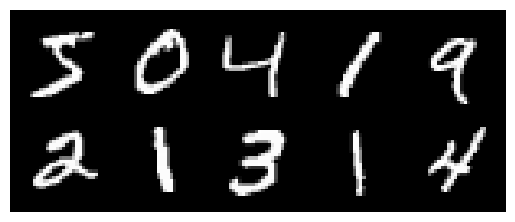

In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# define MNIST dataset and apply transforms
mnist = MNIST(root='data', train=True, transform=ToTensor())

# define class indices (one image from each class)
class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# convert PIL images to PyTorch tensors
images = [mnist[i][0] for i in class_indices]
images = [torch.from_numpy(np.array(image)) for image in images]

# create a grid of 10 images, one from each class
grid = make_grid(images, nrow=5)

# plot the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

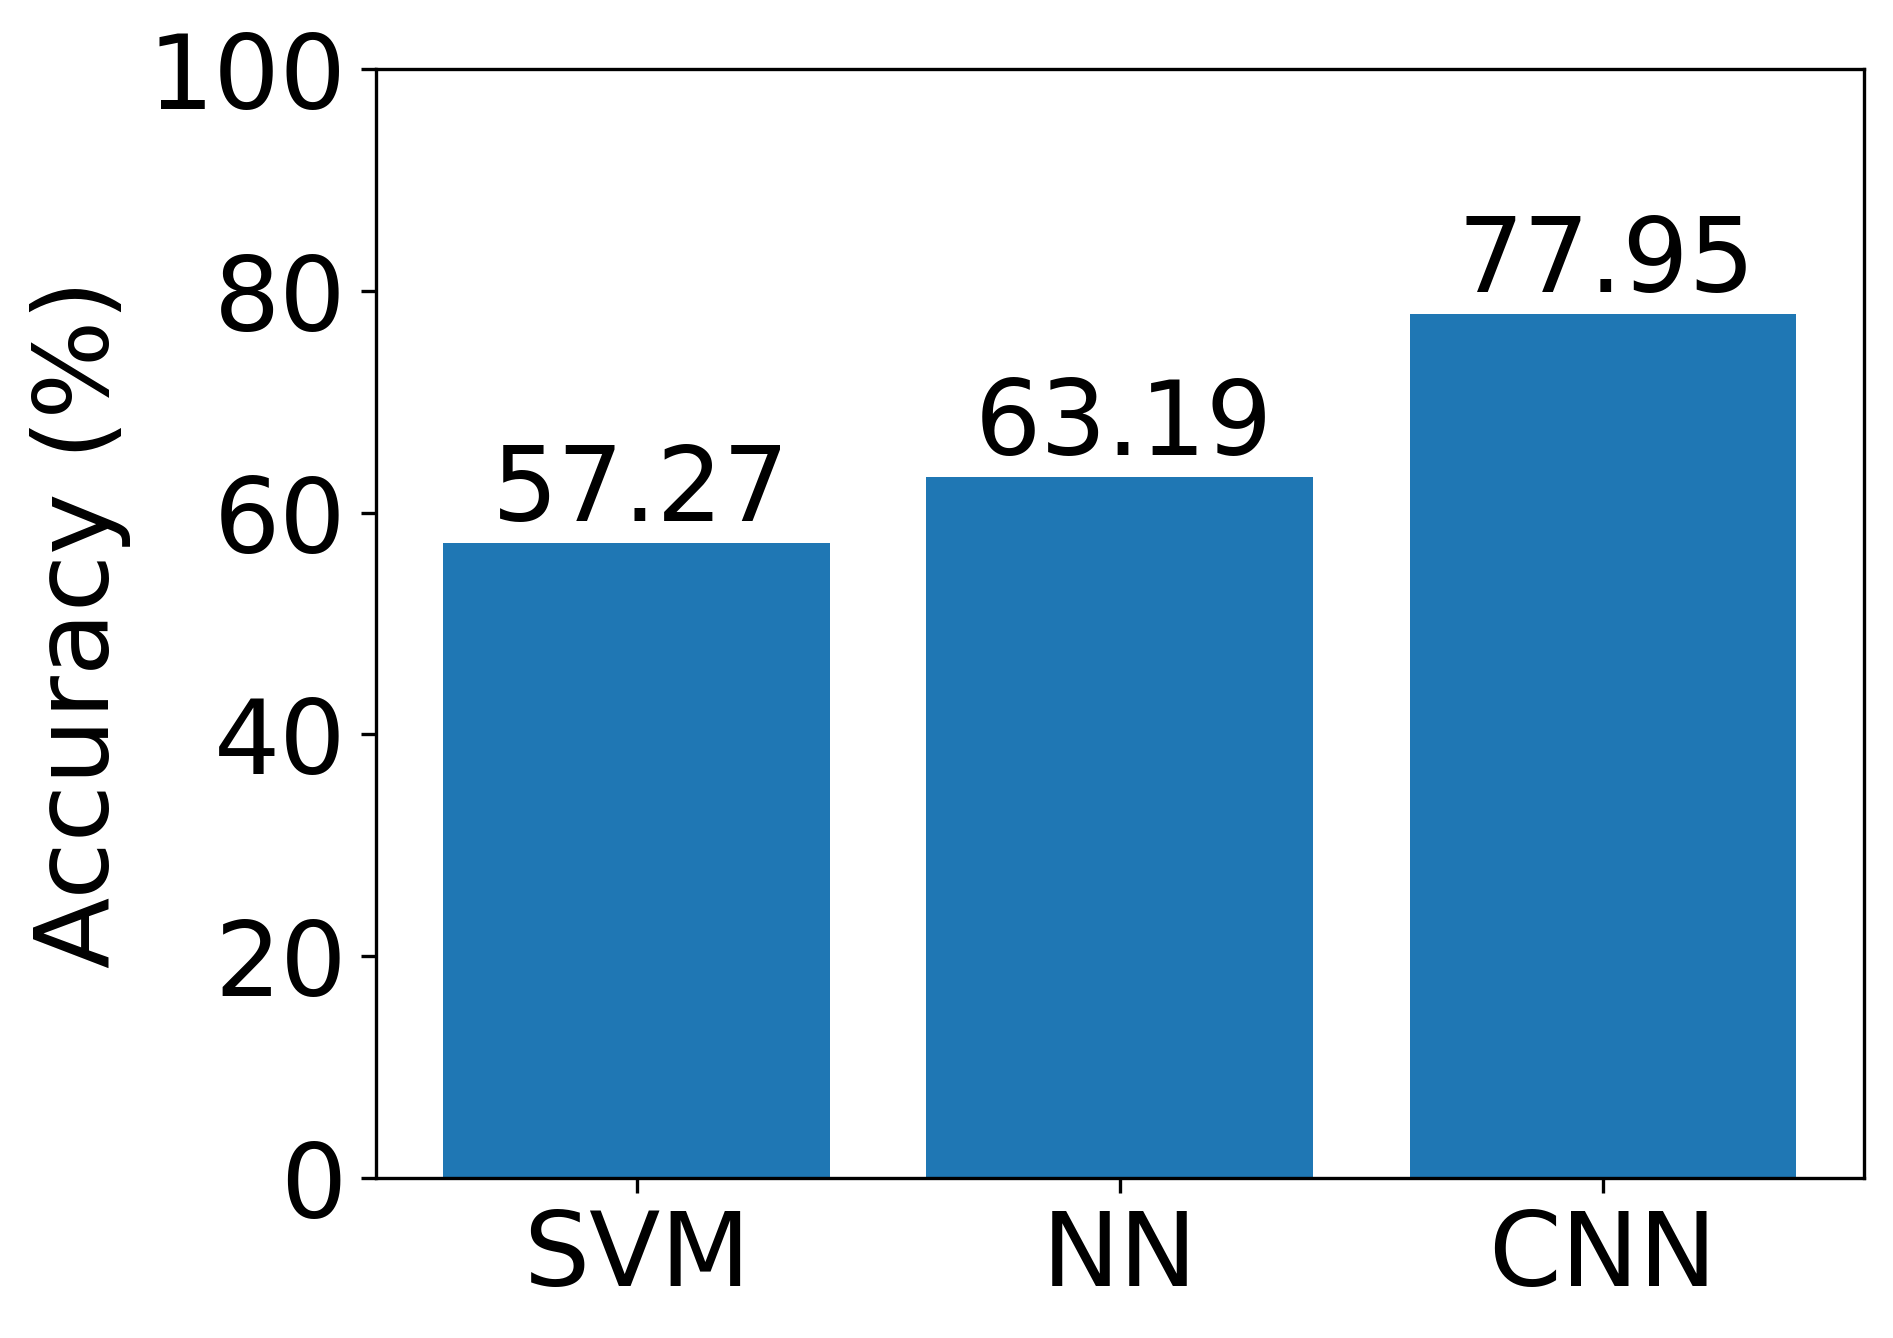

In [ ]:
fig = plt.figure(dpi=300)
methods = ['SVM', 'NN', 'CNN']
acc = [57.27, 63.19, 77.95]
plt.bar(methods,acc)
for i, v in enumerate(acc):
    plt.text(i - 0.3, v + 2, str(v))
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.show()

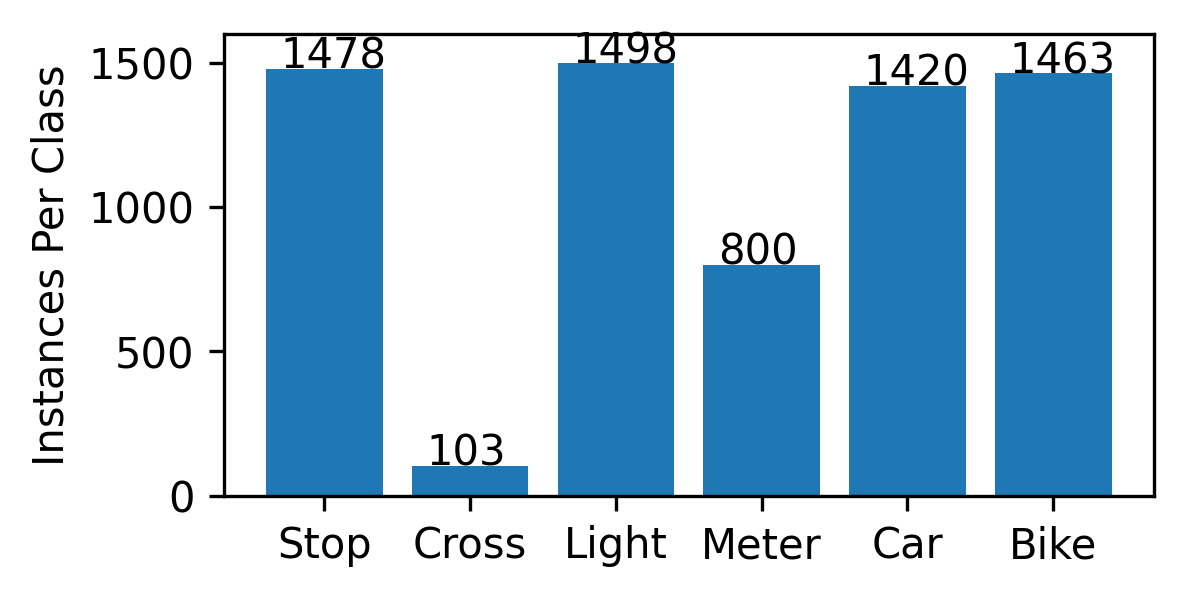

1127.0


In [ ]:
fig = plt.figure(dpi=300, figsize=(4,2))
methods = ['Stop', 'Cross', 'Light', 'Meter', 'Car', "Bike"]
acc = [1478, 103, 1498, 800, 1420, 1463]
plt.bar(methods,acc)
for i, v in enumerate(acc):
    plt.text(i - 0.3, v + 2, str(v))
plt.ylim(0, 1600)
plt.ylabel("Instances Per Class")
plt.show()

print(sum(acc)/6)

#Cefar Dataset Does not serve a purpose just here for reference

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cefar_train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cefar_test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:01<00:00, 105454815.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:


# functions to show an image
classes = ('stop', 'cross', 'light', 'meter', 'car', 'bike', 'person', 'dog', 'cat', 'bear')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cefar_train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

NameError: ignored

In [ ]:
width = 6

class Cefar_nn(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, width, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(width, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 180)
        self.fc2 = nn.Linear(180, 94)
        self.fc3 = nn.Linear(94, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Cnet = Cefar_nn()